# Twitter Sentiment Analysis

## Imports

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from utils import get_dataset, plot_label_distribution
from preprocessing import data_preprocessing, get_X_y

## Explore data

In [3]:
# Retrieves dataset
paths = [os.path.join(os.getcwd(), "dataset/twitter_training.csv"), os.path.join(os.getcwd(), "dataset/twitter_validation.csv")]
data = get_dataset(paths)
data.head()

,id,topic,label,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
# Data preprocessing


,id,topic,label,tweet
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.
75681,6960,johnson&johnson,Neutral,Johnson & Johnson to stop selling talc baby po...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      75682 non-null  int64 
 1   topic   75682 non-null  object
 2   label   75682 non-null  object
 3   tweet   74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


Remarks:
1) Missing values in the tweet column: 686 -> drop these lines

In [6]:
data.isnull().sum()

id         0
topic      0
label      0
tweet    686
dtype: int64

/home/cytech/code_project/machine_learning/classification/multiclass/twitter_sentiment_analysis/utils.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


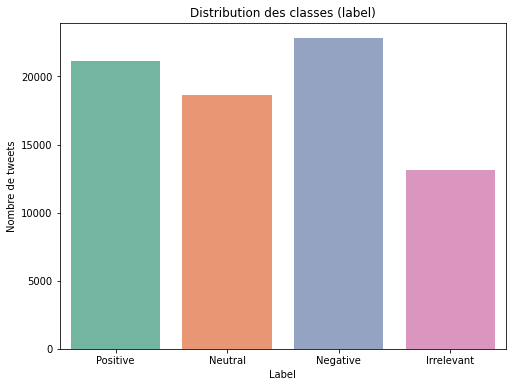

In [7]:
plot_label_distribution(data)

In [8]:
data["label"].value_counts() / len(data)

label
Negative      0.301366
Positive      0.278917
Neutral       0.245805
Irrelevant    0.173912
Name: count, dtype: float64

## Preprocessing

### Stopwords deletion, Stemming, Lemmatization

In [9]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74996 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74996 non-null  int64 
 1   topic   74996 non-null  object
 2   label   74996 non-null  object
 3   tweet   74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [10]:
data["Preprocessed tweet"] = data["tweet"].apply(preprocessing)
data.head()

,id,topic,label,tweet,Preprocessed tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder


### _train, _val, _test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

In [12]:
target = ["label"]
features = ["Preprocessed tweet"]

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train)
print(y_train)

                                      Preprocessed tweet
46708                                           wow know
12946                                nice rhandlerr nice
50856   dey always buy guy fifa career mode growth magic
36536                   live rossiya watch osg show back
57769  please explain sound cut middle damn game came...
...                                                  ...
271    girl fire end credit reason leave borderland f...
11406  xbox series x get hot journalist claim burnt h...
34901  fucking fortnitegame get wont remove sbmm club...
54913  callofduty new beta cold war ridiculously bad ...
31899                             riot like well lost lp

[59996 rows x 1 columns]
            label
46708    Positive
12946    Positive
50856  Irrelevant
36536     Neutral
57769    Negative
...           ...
271      Negative
11406     Neutral
34901    Negative
54913    Negative
31899     Neutral

[59996 rows x 1 columns]


### Encoder, Model

1) We will use a One Hot encoding because there is no ordinal relationship between positive, neutral, negative and irrelevant. We have an order relationship for the first three but not the last, so we'll use a One Hot Encoder.
2) The TfidfVectorizer is used to transform a text into a numerical representation by weighting each word according to its frequency in the document and its inverse in the set of documents, in order to favour terms specific to the text and reduce the importance of common terms.

In [13]:
# Target
le = LabelEncoder()
y_train = le.fit_transform(y_train)  
y_test = le.transform(y_test)       

/home/cytech/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cytech/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [14]:
# Features
ct = ColumnTransformer([
    ("text preprocessor", TfidfVectorizer(), "Preprocessed tweet")
])
clf = Pipeline([
    ('preprocessing', ct),
    ('model', MultinomialNB())
])

### Naive Bayes

In [15]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text preprocessor',
                                                  TfidfVectorizer(),
                                                  'Preprocessed tweet')])),
                ('model', MultinomialNB())])

In [16]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.42      0.58      2609
           1       0.65      0.88      0.75      4525
           2       0.80      0.62      0.70      3679
           3       0.69      0.80      0.74      4187

    accuracy                           0.71     15000
   macro avg       0.77      0.68      0.69     15000
weighted avg       0.75      0.71      0.70     15000



Analyse des Metrics
Precision :

La precision mesure la capacité du modèle à identifier correctement les exemples positifs parmi les exemples classés comme positifs.
Pour la classe 0, la précision est très élevée à 0.94, ce qui signifie que lorsque le modèle prédit la classe 0, il a une forte probabilité que cette prédiction soit correcte.
En revanche, la classe 1 a une précision de 0.65, ce qui indique que le modèle fait plus d'erreurs en classifiant des exemples qui devraient être d'autres classes comme appartenant à la classe 1.
Les autres classes (2 et 3) ont des précisions respectives de 0.80 et 0.69, indiquant une performance intermédiaire.
Recall :

Le recall (ou sensibilité) indique la capacité du modèle à détecter tous les exemples positifs pour chaque classe.
La classe 1 a le meilleur recall de 0.88, ce qui montre que le modèle identifie bien cette classe, tandis que la classe 0 a un recall de seulement 0.42, suggérant que de nombreux exemples de la classe 0 ne sont pas détectés.
Les classes 2 et 3 montrent des valeurs de recall modérées, avec respectivement 0.62 et 0.80.
F1-Score :

Le F1-score est la moyenne harmonique de la précision et du rappel, fournissant une mesure globale de la performance du modèle.
La classe 1 a le meilleur F1-score à 0.75, indiquant un bon équilibre entre précision et rappel. Les classes 2 et 3 sont également dans une gamme acceptable avec des F1-scores de 0.70 et 0.74 respectivement, tandis que la classe 0 présente un F1-score de 0.58, indiquant des performances sous-optimales.
Support :

Le support indique le nombre d'exemples réels dans chaque classe. Cela donne une idée de la distribution des classes dans le jeu de données.
La classe 1 a le plus grand nombre d'exemples (4525), tandis que la classe 0 a le plus petit support (2609).
Moyenne des Scores
Accuracy : La précision globale du modèle est de 0.71, ce qui signifie que le modèle a correctement prédit la classe pour 71% des instances du test. Cependant, cela masque des performances très variées pour chaque classe.
Macro Average : Les moyennes macro pour la précision, le rappel et le F1-score sont respectivement de 0.77, 0.68, et 0.69, indiquant que, bien que la performance soit globalement acceptable, il existe des variations significatives entre les classes.
Weighted Average : Les moyennes pondérées pour ces métriques sont légèrement inférieures, reflétant l'importance des classes plus fréquentes dans les résultats globaux.

### Random Forest Classifier

In [17]:
clf = Pipeline([
    ('preprocessing', ct),
    ('model', RandomForestClassifier())
])
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text preprocessor',
                                                  TfidfVectorizer(),
                                                  'Preprocessed tweet')])),
                ('model', RandomForestClassifier())])

In [18]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.91      2609
           1       0.92      0.92      0.92      4525
           2       0.86      0.92      0.89      3679
           3       0.90      0.91      0.91      4187

    accuracy                           0.91     15000
   macro avg       0.91      0.90      0.90     15000
weighted avg       0.91      0.91      0.91     15000



### RNN

In [19]:
!pip install tensorflow

     |████████████████████████████████| 479.6 MB 36 kB/s s eta 0:00:01  |                                | 1.4 MB 2.3 MB/s eta 0:03:27     |███▊                            | 55.3 MB 14.0 MB/s eta 0:00:31     |███████████                     | 165.4 MB 8.3 MB/s eta 0:00:38     |████████████                    | 180.3 MB 3.4 MB/s eta 0:01:28     |██████████████▏                 | 212.0 MB 3.3 MB/s eta 0:01:20     |████████████████▍               | 244.9 MB 21.6 MB/s eta 0:00:11   | 290.3 MB 8.5 MB/s eta 0:00:23��████████████████████████▏   | 422.8 MB 12.1 MB/s eta 0:00:05     |██████████████████████████████▊ | 459.9 MB 16.1 MB/s eta 0:00:02     |███████████████████████████████▉| 476.7 MB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 25.6 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 1.1 MB/s eta 0:00:011
     |████████████████████████████████| 5.8 MB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 13.2 MB/s eta 0:00:01
     |██

In [ ]:
from tensorflow.keras